# Understanding Fairness Through Analyzing IBM's AIF360

#### Welcome to a introductory module to IBM's AIF360. AIF360 is a AI Fairness package that allows users to evaluate their models for bias during preprocessing, during processing and post-processing. Furthermore, the package allows interference with the model in the three stages mentioned afore, and also serves as a tool to create fairness in your own AI or ML model.

### Importing Packages and Data

In [80]:
%%bash
pip install aif360

In [97]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
# setting random seed
np.random.seed(218)
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from IPython.display import Markdown, display

#### We will be using the AdultDataSet which serves as a CENSUS income dataset for adults with demographic information. The sensitive variable, or in other words, the variable that creates the biased "priviledge" is male.

In [82]:
single_protected = ['sex'] 
single_privileged = [['Male']]
ad = AdultDataset(protected_attribute_names=single_protected,
                  privileged_classes = single_privileged, 
                  categorical_features=[], 
                  # even if the priviledged features are not specified, they are kept
                  features_to_keep=['age', 'education-num'])
print(ad.feature_names)
print(ad.label_names)

/opt/conda/lib/python3.7/site-packages/aif360/datasets/standard_dataset.py:121: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  priv = np.logical_or.reduce(np.equal.outer(vals, df[attr]))
/opt/conda/lib/python3.7/site-packages/aif360/datasets/standard_dataset.py:142: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  df[label_name]))


['age', 'education-num', 'sex']
['income-per-year']


In [83]:
dataset_orig_train, dataset_orig_test = ad.split([0.7], shuffle=True)
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

#### Explore the Data

In [84]:
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 3)


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'education-num', 'sex']


#### After we assign the priviledged and under-priviledged groups, we calculate the baseline fairness.

In [85]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.192812


#### This value shows that there is a mean difference between priviledged and underpriviledged groups, and the biad towards the privildeged group.

# Introduction of Fainess Algorithm: Inprocessing

#### I will be introducing, executing and walking you through one of the inprocessing techniques that IBM AI360 has created to introduce fairness to the model. The interesting aspect of inprocess algorithm is the intervention the algorithm makes in the model, not post or pre analysis. 

#### Meta Fair Classifier takes the fairness metric, BinaryLabelDatasetMetric, as an imput and optimizes the algorithm for it. It is essentially passing the fairness metric as a loss function, and trianing the model, while sacrificing from some of the accuracy, to be more fair. The example code for this introductory modelu is inspired by https://github.com/IBM/AIF360/blob/master/aif360/algorithms/inprocessing/meta_fair_classifier.py.

#### Below we create the MetaFairClassifier class, and then create the fit and predict functions for the model. Here, we train the biased model, where algorithm has a tau of 0, motivating it to not be fair:

In [86]:
import numpy as np
import copy
from aif360.algorithms import Transformer
from aif360.algorithms.inprocessing.celisMeta.FalseDiscovery import FalseDiscovery
from aif360.algorithms.inprocessing.celisMeta.StatisticalRate import StatisticalRate
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier

mfc = MetaFairClassifier(tau=0, sensitive_attr="sex")
mfc.fit(dataset_orig_train)

#### Make Predictions

In [87]:
dataset_bias_test = mfc.predict(dataset_orig_test)

#### Assess Bias

In [88]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_bias_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_orig_train.mean_difference())
print("We can see that the mean outcome is still biased, towards the variable as before - sex: Male.")

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.062442
We can see that the mean outcome is still biased, towards the variable as before - sex: Male.


#### Accuracy of the Unconstrained Model

In [99]:
predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in list(dataset_bias_test.labels)]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
print("Accuracy Score:", round(accuracy_score(predictions, y_test),3))

Accuracy Score: 0.778


#### Now we will change the tau values in the algorithm to introduce fairness into the model, to see how the accuracy score and the fairness metric changes with it.

In [104]:
tau_list = np.linspace(0.01, 0.90, 10)
accuracies = []
mean_difference = []
for tau in tau_list:
    print("#########################################")
    print("Tau: %.2f" % tau)
    mfc = MetaFairClassifier(tau=tau, sensitive_attr="sex")
    mfc.fit(dataset_orig_train)
    predictions_mfc = mfc.predict(dataset_orig_test)
    pred_labels = predictions_mfc.labels
    predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in pred_labels]
    metric_orig_train = BinaryLabelDatasetMetric(predictions_mfc, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    mean_diff = metric_orig_train.mean_difference()
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % mean_diff)
    acc = accuracy_score(predictions, y_test)
    print("Test Accuracy Score:", round(acc,3))
    accuracies.append(acc)
    mean_difference.append(mean_diff)

#########################################
Tau: 0.01
Training Accuracy:  0.6112784813829009 , Training gamma:  0.6925396834753267
Difference in mean outcomes between unprivileged and privileged groups = -0.119845
Test Accuracy Score: 0.613
#########################################
Tau: 0.12
Training Accuracy:  0.605487144988154 , Training gamma:  0.6898865741357078
Difference in mean outcomes between unprivileged and privileged groups = -0.101610
Test Accuracy Score: 0.608
#########################################
Tau: 0.23
Training Accuracy:  0.6044341747345637 , Training gamma:  0.6901179588784879
Difference in mean outcomes between unprivileged and privileged groups = -0.101990
Test Accuracy Score: 0.606
#########################################
Tau: 0.34
Training Accuracy:  0.5963321536166604 , Training gamma:  0.6939808846675622
Difference in mean outcomes between unprivileged and privileged groups = -0.104616
Test Accuracy Score: 0.6
#########################################
Tau: 

IndexError: list index out of range

# Results and Analysis

#### Graphing (with unbiased algorithm)

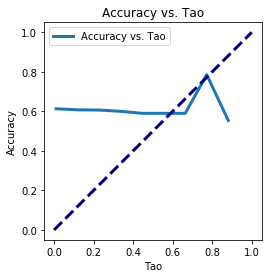

In [125]:
import matplotlib.pyplot as plot
figure = plot.figure()
axe = figure.gca()
axe.plot(tau_list[:-1], accuracies, lw=3, label="Accuracy vs. Tao")
axe.set_xlabel("Tao")
axe.set_ylabel("Accuracy")
axe.set_title("Accuracy vs. Tao")
axe.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
axe.legend()
axe.set_aspect('equal')

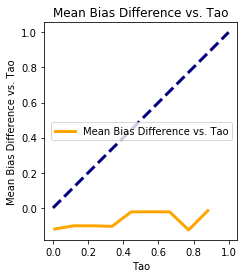

In [124]:
import matplotlib.pyplot as plot
figure = plot.figure()
axe = figure.gca()
axe.plot(tau_list[:-1], mean_difference, lw=3,color='orange', label="Mean Bias Difference vs. Tao")
axe.set_xlabel("Tao")
axe.set_ylabel("Mean Bias Difference vs. Tao")
axe.set_title("Mean Bias Difference vs. Tao")
axe.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
axe.legend()
axe.set_aspect('equal')

#### Interpretation

The graph shows that, for almost all the Tao values, the accuracy goes down as the tao goes up. The mean bia difference is loves when tao is 0.88, coming all the way down to -0.015 from -0.19 biased model. We can clearly observe a trade-off between the accuracy score and bias reduction, as expected.

#### Other Metrices to Use
1. FDR (False Discovery Rate): is a method of conceptualizing the rate of type I errors in null hypothesis testing when conducting multiple comparisons. (from Wikipedia) The idea of false discovery rate is to make the total number of FALSE discoveries (false positive + false negative) LOWER as a percentage of the overall discoveries.

#### FDR Code Implementation

We implement the FDR metric to assess the "accuracy" of the model from another bia related metric. Below we compare the best model from the iterations above, with the unconstrained model. This proves the reduction in bias. 

In [129]:
from aif360.algorithms.inprocessing.celisMeta.utils import getStats

#Unconstrained Model
mfc = MetaFairClassifier(tau=0, sensitive_attr="sex")
mfc.fit(dataset_orig_train)
dataset_bias_test = mfc.predict(dataset_orig_test)


predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in list(dataset_bias_test.labels)]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)["sex"]

acc, sr, unconstrainedFDR = getStats(y_test, predictions, x_control_test)
print(unconstrainedFDR)

Accuracy :  3254 14653 0.777929434245547
SR tau :  0.24060062422550277
FPR tau :  0.43600739741090616
FNR tau :  0.8609189723320158
TPR tau :  0.31004901960784315
TNR tau :  0.980340417865866
AR tau :  0.8224361467717171
FDR tau :  0.4288194444444444
FOR tau :  0.3872744450835204
PPR tau :  0.4588815789473684
NPR tau :  0.8136439105306991
0.4288194444444444


In [130]:
# the best model from the iterations above had a TAO of 0.88.
mfc = MetaFairClassifier(tau=0.88, sensitive_attr="sex")
mfc.fit(dataset_orig_train)

Training Accuracy:  0.5383017929743485 , Training gamma:  0.6980020035235538


NameError: name 'biased_model' is not defined

In [131]:
dataset_bias_test = mfc.predict(dataset_orig_test)

predictions = list(dataset_debiasing_test.labels)
predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in predictions]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)["sex"]

acc, sr, fdr = getStats(y_test, predictions, x_control_test)
print(fdr, unconstrainedFDR)

Accuracy :  5672 14653 0.6129120316658705
SR tau :  0.8000013123449397
FPR tau :  0.9130276132539338
FNR tau :  0.6943346508563901
TPR tau :  0.9308788818438468
TNR tau :  0.9253680086167871
AR tau :  0.93946485365946
FDR tau :  0.6808922089217645
FOR tau :  0.39480000000000004
PPR tau :  0.41435204806001147
NPR tau :  0.9341294990910202
0.6808922089217645 0.4288194444444444


In [132]:
assert(fdr >= unconstrainedFDR)